In [1]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
start=0.0001
end=0.02
T=1000
batch_size=8
beta=torch.linspace(start, end, T).to(device)
alpha_bas=torch.cumprod(1.0-beta, dim=0).to(device)

In [4]:
from datasets import load_dataset

In [5]:
dts_name="huggan/smithsonian_butterflies_subset"
data=load_dataset(dts_name, split='train')
data

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [6]:
img_size=128
transform=transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
def preprocess(dts):
    images=[transform(img.convert('RGB')) for img in dts['image']]
    return {'images': images}
data.set_transform(preprocess)
data

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [8]:
from torch.utils.data import DataLoader
data_loader=DataLoader(data, batch_size=batch_size)

In [9]:
import torchvision

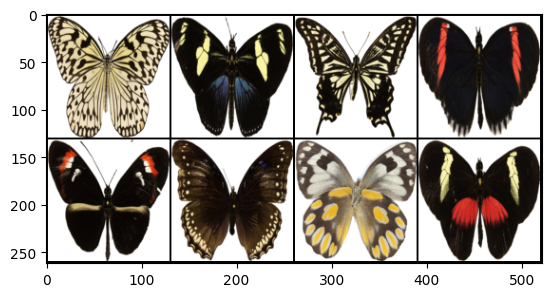

In [10]:
batch=next(iter(data_loader))
grid=torchvision.utils.make_grid(batch['images'], nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(0,1))

In [11]:
def add_noise(x, t):
    noise=torch.randn(x.shape).to(device)
    img_noise=torch.sqrt(alpha_bas[t])*x+torch.sqrt(1-alpha_bas[t])*noise
    return img_noise

In [12]:
batch['images'].shape

torch.Size([8, 3, 128, 128])

In [13]:
batch['images'][0].shape

torch.Size([3, 128, 128])

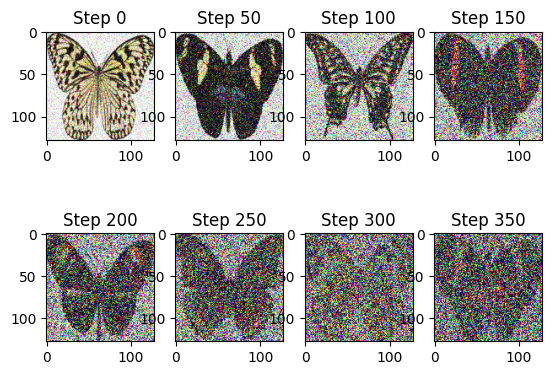

In [14]:
plt.subplots(2,4)
for i in range(batch['images'].shape[0]):
    img=add_noise(batch['images'][i].to(device), 50*(i+1))
    plt.subplot(2,4,i+1)
    plt.imshow(img.permute(1,2,0).cpu().clip(0,1))
    plt.title(f'Step {i*50}')

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from diffusers import UNet2DModel

In [16]:
model=UNet2DModel(
    sample_size=img_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64,128,128,256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)


In [17]:
sum([p.numel() for p in model.parameters()])

18536323

In [18]:
len(data_loader)

125

In [19]:
T=1000
opt=torch.optim.AdamW(model.parameters(), lr=0.05)

In [19]:
n_epoch=3
losses=[]
for epoch in range(n_epoch):
    Loss=0
    for i, batch in tqdm(enumerate(data_loader), total=len(data_loader)):
        imgs=batch['images'].to(device)
        opt.zero_grad()
        #ts=torch.randint(0,T, (batch_size,), device=device).long()
        ts=torch.ones(batch_size, device=device)*(T-1)
        noise_img=[]
        eps=torch.randn(imgs.shape).to(device)
        bs=imgs.shape[0]
        for k in range(batch_size):
            noise_img.append(add_noise(imgs[k], T-1).to(device))
        noise_img=torch.stack(noise_img, dim=0)
        eps_hat=model(noise_img, ts)
        loss=F.mse_loss(eps_hat['sample'], eps)
        loss.backward()
        opt.step()
        Loss+=loss
        losses.append(loss.item())
        if i%100==0:
            print(eps_hat['sample'].shape)
    #if epoch%2==0:
    print(f'Epoch {epoch}, Loss: {Loss/len(data_loader)} ')


  1%|          | 1/125 [00:00<01:21,  1.53it/s]

torch.Size([8, 3, 128, 128])


 81%|████████  | 101/125 [00:42<00:10,  2.36it/s]

torch.Size([8, 3, 128, 128])


100%|██████████| 125/125 [00:53<00:00,  2.35it/s]


Epoch 0, Loss: 1.3615775108337402 


  1%|          | 1/125 [00:00<00:51,  2.41it/s]

torch.Size([8, 3, 128, 128])


 81%|████████  | 101/125 [00:42<00:10,  2.32it/s]

torch.Size([8, 3, 128, 128])


100%|██████████| 125/125 [00:53<00:00,  2.36it/s]


Epoch 1, Loss: 1.0000630617141724 


  1%|          | 1/125 [00:00<00:51,  2.38it/s]

torch.Size([8, 3, 128, 128])


 81%|████████  | 101/125 [00:43<00:10,  2.29it/s]

torch.Size([8, 3, 128, 128])


100%|██████████| 125/125 [00:53<00:00,  2.32it/s]

Epoch 2, Loss: 0.9997648596763611 


In [23]:
eps_hat['sample'].shape

torch.Size([8, 3, 128, 128])

In [25]:
from diffusers.utils import make_image_grid

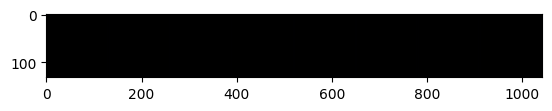

In [32]:
img_grid=torchvision.utils.make_grid(noise_pred, nrow=8)
plt.imshow(img_grid.permute(1,2,0).clip(0,1).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.5219026..4.532563].


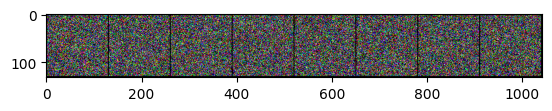

In [21]:
noise_grid=torchvision.utils.make_grid(noise_img, nrow=8)
plt.imshow(noise_grid.permute(1,2,0).cpu())

In [19]:
import seaborn as sns
sns.set()

In [1]:
plt.plot(losses)   

NameError: name 'plt' is not defined

In [25]:
def sampling(x,ts_sample):
    alpha=1-torch.linspace(start, end, ts_sample)
    alpha_bas=torch.cumprod(alpha, dim=0)
    model.eval()
    x=x.to(device)
    with torch.no_grad():
        for t in torch.linspace(ts_sample-1,1, ts_sample-1, device=device).long():
            if t>1:
                z=torch.randn_like(x) 
            else:
                z=torch.zeros_like(x)
            coef1=1/torch.sqrt(alpha[t])
            coef2=(1-alpha[t])/(torch.sqrt(1-alpha_bas[t]))
            x_hat=model(x,t.repeat(batch_size))['sample']
            x=coef1*(x-coef2*x_hat)+torch.sqrt(beta[t])*z #.unsqueeze(dim=0).repeat(batch_size,1,1,1)
    return x
    

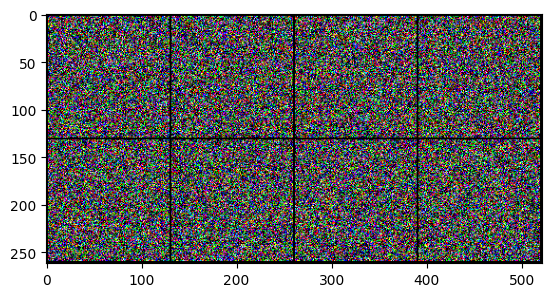

In [26]:
img=torch.randn((8,3,128,128))
img_grd=torchvision.utils.make_grid(img, nrow=4)
plt.imshow(img_grd.permute(1,2,0).clip(0,1))
#plt.imshow(img.permute(2,1,0))

In [27]:
img_pred=sampling(img.to(device), 40)

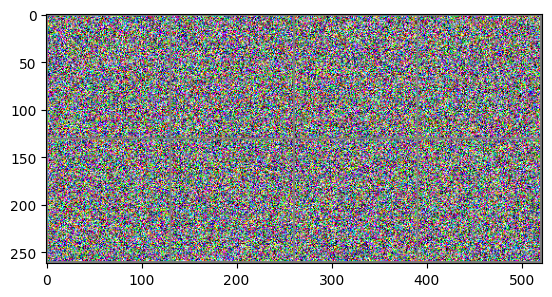

In [28]:
img_gd=torchvision.utils.make_grid(img_pred, nrow=4)
plt.imshow(img_gd.permute(1,2,0).cpu().clip(-1,1)*0.5+0.5)